<a href="https://colab.research.google.com/github/CooperJB710/DS2002-Data-Project-1/blob/main/ETL_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [238]:
!pip install mysql-connector-python

In [239]:
# Cell 1: Imports & Globals

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector

MYSQL_HOST = "localhost"
MYSQL_USER = "root"
MYSQL_PASS = "ViP84Gb9dNyb"
MYSQL_DB   = "etl_pipeline_database"

STATE_MAP = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
    "District of Columbia": "DC", "Florida": "FL", "Georgia": "GA", "Hawaii": "HI",
    "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA",
    "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME",
    "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN",
    "Mississippi": "MS", "Missouri": "MO", "Montana": "MT", "Nebraska": "NE",
    "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM",
    "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH",
    "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI",
    "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX",
    "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA",
    "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY"
}

# Reverse map so that "AK" -> "Alaska"
ABBR_TO_FULL = {abbrev: name for name, abbrev in STATE_MAP.items()}

CDC_API_JSON_URL = ""
CSV_PATH = "/content/NST-EST2023-POPCHG2020_2023.csv"
YEAR_LIST = [2020, 2021, 2022]

pd.options.display.float_format = '{:,.0f}'.format


In [240]:
# Cell 2: Extract API
# Fetch pages of 1000 rows, keep only 2020–2022, rename blanks, fill invalid with zero.
def extract_cdc_vaccination_data():
    chunk_size = 1000
    offset = 0
    all_chunks = []

    while True:
        params = {"$limit": chunk_size, "$offset": offset}
        try:
            resp = requests.get(CDC_API_JSON_URL, params=params, timeout=30)
        except Exception as e:
            print(f"Request error: {e}")
            break

        if resp.status_code != 200 or not resp.text.strip():
            print("No more data or bad response.")
            break

        chunk_df = pd.json_normalize(resp.json())
        if chunk_df.empty:
            print("Empty chunk encountered.")
            break

        all_chunks.append(chunk_df)
        offset += chunk_size

    if not all_chunks:
        print("No data retrieved from the API.")
        return pd.DataFrame()

    df_raw = pd.concat(all_chunks, ignore_index=True)
    needed = ["date","location","administered"]
    for col in needed:
        if col not in df_raw.columns:
            df_raw[col] = np.nan

    df = df_raw[needed].copy()
    df["date"] = df["date"].astype(str).str[:4]
    df["year"] = pd.to_numeric(df["date"], errors="coerce")
    df.drop(columns="date", inplace=True)
    df = df[df["year"].isin(YEAR_LIST)]
    df["location"] = df["location"].fillna("").str.upper().str.strip()
    df["administered"] = pd.to_numeric(df["administered"], errors="coerce")
    df.dropna(subset=["year","location","administered"], inplace=True)
    df = df[df["location"] != ""]
    df.drop_duplicates(subset=["year","location"], keep="first", inplace=True)
    df.rename(columns={"location":"State"}, inplace=True)
    return df[["year","State","administered"]]


In [241]:
# Cell 3: Load Census
# Load CSV, rename population columns, remove empty, keep relevant columns.
def load_census_population_data(csv_path):
    try:
        df_csv = pd.read_csv(csv_path, encoding="latin-1", low_memory=False)
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return pd.DataFrame()

    if df_csv.empty:
        print("Census CSV contains no data.")
        return pd.DataFrame()

    df_csv.rename(columns={
        "NAME":"State",
        "POPESTIMATE2020":"popestimate2020",
        "POPESTIMATE2021":"popestimate2021",
        "POPESTIMATE2022":"popestimate2022"
    }, inplace=True, errors="ignore")

    for col in ["popestimate2020","popestimate2021","popestimate2022"]:
        if col in df_csv.columns:
            df_csv[col] = pd.to_numeric(df_csv[col], errors="coerce")

    df_csv["State"] = df_csv["State"].fillna("").str.strip()
    df_csv = df_csv[df_csv["State"] != ""]

    keep_cols = ["State","popestimate2020","popestimate2021","popestimate2022"]
    existing = [c for c in keep_cols if c in df_csv.columns]
    df_csv = df_csv[existing]

    if df_csv.empty:
        print("Warning: After cleaning, no rows remain.")
    return df_csv


In [242]:
# Cell 4: Transform
# Map abbreviations->full names, pivot by year, merge with census, fill blanks with 0.
def transform_data(df_api, df_csv):
    if df_api.empty or df_csv.empty:
        print("One or both DataFrames are empty. Skipping merge.")
        return pd.DataFrame()

    df_api["StateFull"] = df_api["State"].map(ABBR_TO_FULL)
    df_api = df_api.dropna(subset=["StateFull"])

    pivoted = df_api.pivot(index="StateFull", columns="year", values="administered").reset_index()

    for y in YEAR_LIST:
        col_old = y
        col_new = f"vaccinated_pop{y}"
        if col_old in pivoted.columns:
            pivoted.rename(columns={col_old:col_new}, inplace=True)
        else:
            pivoted[col_new] = 0

    merged = pd.merge(pivoted, df_csv, left_on="StateFull", right_on="State", how="inner")
    final_cols = [
        "State","popestimate2020","popestimate2021","popestimate2022",
        "vaccinated_pop2020","vaccinated_pop2021","vaccinated_pop2022"
    ]
    df_final = merged[final_cols].copy()

    for col in ["vaccinated_pop2020","vaccinated_pop2021","vaccinated_pop2022"]:
        df_final.loc[:, col] = df_final[col].fillna(0).round().astype(int)

    for col in ["popestimate2020","popestimate2021","popestimate2022"]:
        df_final.loc[:, col] = df_final[col].fillna(0).round().astype(int)

    return df_final


In [243]:
# Cell 5: Analyze
# Simple analysis, correlation, difference columns, plots if data not empty.
def analyze_data(df_final):
    if df_final.empty:
        print("No data to analyze.")
        return

    print(f"Records: {len(df_final)}")
    print(df_final.head(5))

    print("\nFull Statistical Summary:")
    try:
        print(df_final.describe())
    except ValueError as e:
        print(f"Cannot describe DataFrame: {e}")

    numeric_cols = [
        "popestimate2020","popestimate2021","popestimate2022",
        "vaccinated_pop2020","vaccinated_pop2021","vaccinated_pop2022"
    ]
    numeric_cols = [c for c in numeric_cols if c in df_final.columns]
    if numeric_cols:
        corr_matrix = df_final[numeric_cols].corr()
        print("\nCorrelation Matrix (selected columns):")
        print(corr_matrix)

    for y in YEAR_LIST:
        pop_col = f"popestimate{y}"
        vac_col = f"vaccinated_pop{y}"
        diff_col = f"difference_{y}"
        if pop_col in df_final.columns and vac_col in df_final.columns:
            df_final.loc[:, diff_col] = df_final[pop_col] - df_final[vac_col]

    for y in YEAR_LIST:
        pop_col = f"popestimate{y}"
        vac_col = f"vaccinated_pop{y}"
        if pop_col in df_final.columns and vac_col in df_final.columns:
            df_final.plot.scatter(x=pop_col, y=vac_col, title=f"Population vs. Vaccinated ({y})")
            plt.show()


In [244]:
import mysql.connector

def store_data_in_mysql(final_df):
    try:
        conn = mysql.connector.connect(
            host=MYSQL_HOST,
            user=MYSQL_USER,
            password=MYSQL_PASS,
            database=MYSQL_DB
        )
        cursor = conn.cursor()
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS vaccination_data (
                State VARCHAR(50),
                popestimate2020 INT,
                popestimate2021 INT,
                popestimate2022 INT,
                vaccinated_pop2020 INT,
                vaccinated_pop2021 INT,
                vaccinated_pop2022 INT
            )
        """)
        conn.commit()
        cursor.close()
        conn.close()
    except mysql.connector.Error as err:
        print(f"ERROR: MySQL connect failed. {err.errno}: {err.msg}")

Extracting CDC data with offset-based paging...
Empty chunk encountered.
Loading local census CSV...
       year State  administered
1216   2022    CT       8883525
1217   2022   DD2       9291393
1218   2022    FM        194546
1219   2022    NJ      19503839
1220   2022    OK       6660547
...     ...   ...           ...
37410  2020    AZ         43667
37411  2020    VT         12241
37412  2020    MI         68398
37413  2020    NV         25645
37414  2020    MD         50312

[195 rows x 3 columns]
               State  popestimate2020  popestimate2021  popestimate2022
0      United States        331526933        332048977        333271411
1   Northeast Region         57430477         57243423         57026847
2        New England         15057898         15106108         15120739
3    Middle Atlantic         42372579         42137315         41906108
4     Midwest Region         68969794         68850246         68783028
..               ...              ...              ...     

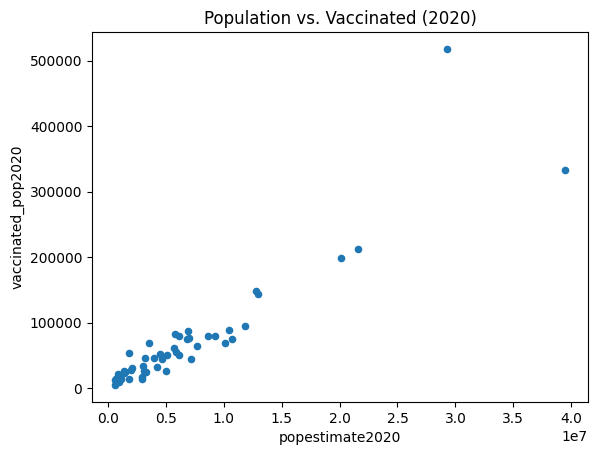

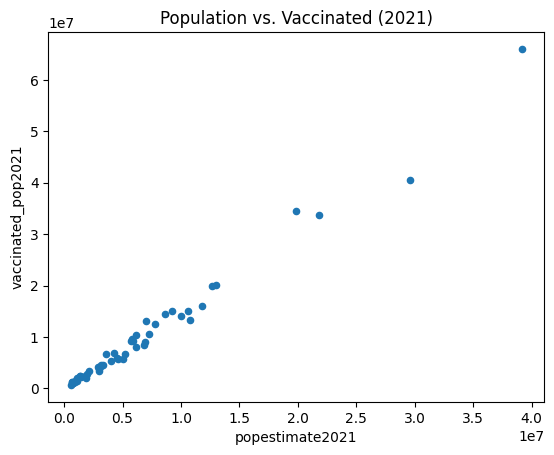

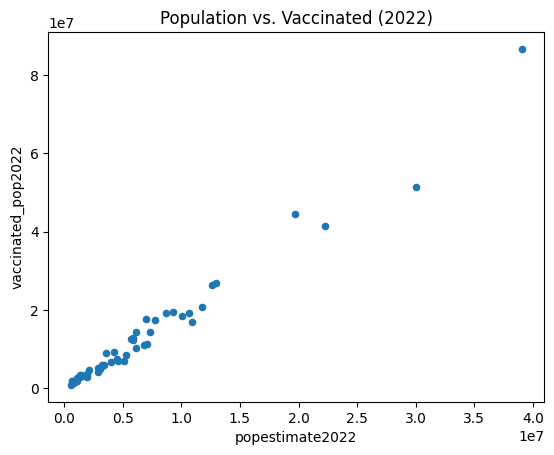

Store in MySQL...
ERROR: MySQL connect failed. 2002: Can't connect to local MySQL server through socket '%-.100s' (%s) (Warning: not all arguments converted during string formatting)
ETL complete.


In [245]:
def main():
    print("Extracting CDC data with offset-based paging...")
    df_api = extract_cdc_vaccination_data()

    print("Loading local census CSV...")
    csv_path = "/content/NST-EST2023-POPCHG2020_2023.csv"
    df_csv = load_census_population_data(csv_path)
    print(df_api)
    print(df_csv)
    print("Transform & merge...")
    df_merged = transform_data(df_api, df_csv)
    print(df_merged)
    print("Analyze data...")
    analyze_data(df_merged)

    print("Store in MySQL...")
    store_data_in_mysql(df_merged)

    print("ETL complete.")

if __name__ == "__main__":
    main()